# Introduction

This notebook contains code and explanations for various prompt engineering techniques. It also implicitly acts as a demo for LangChain.

# Setup

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv("/home/vimal/keys/.env")

True

# The Data
The dataset we will be using contains user reviews for games Steam. We also have a set of data which quantifies the rating of a game on a scale of 1-9. Combining these two datasets we shall be solving a small set of problems.

In [2]:
DATA_PATH = "data/"
reviews = pd.read_csv(os.path.join(DATA_PATH, "reviews.csv"))
ratings = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"))

In [3]:
reviews.head(5)

,app_id,app_name,review_text,review_score,review_votes,review_id
0,105600,Terraria,You can be a werewolf riding a unicorn while s...,1,0,0
1,105600,Terraria,You should by 8 copies of this game and go aro...,1,0,1
2,105600,Terraria,Introduction,1,1,2
3,105600,Terraria,"If you have friends, this is a great game to p...",1,1,3
4,105600,Terraria,A Generic Comparison of Terraria versus Minecr...,1,0,4


In [4]:
ratings.head(5)

,Unnamed: 0,id,name,overall_review,overall_score
0,0,105600,Terraria,Overwhelmingly Positive,9
1,1,570,Dota 2,Very Positive,8
2,2,252950,Rocket League,Very Positive,8
3,3,391540,Undertale,Overwhelmingly Positive,9
4,4,252490,Rust,Mostly Positive,6


# Stats
## Number of Reviews Per Game

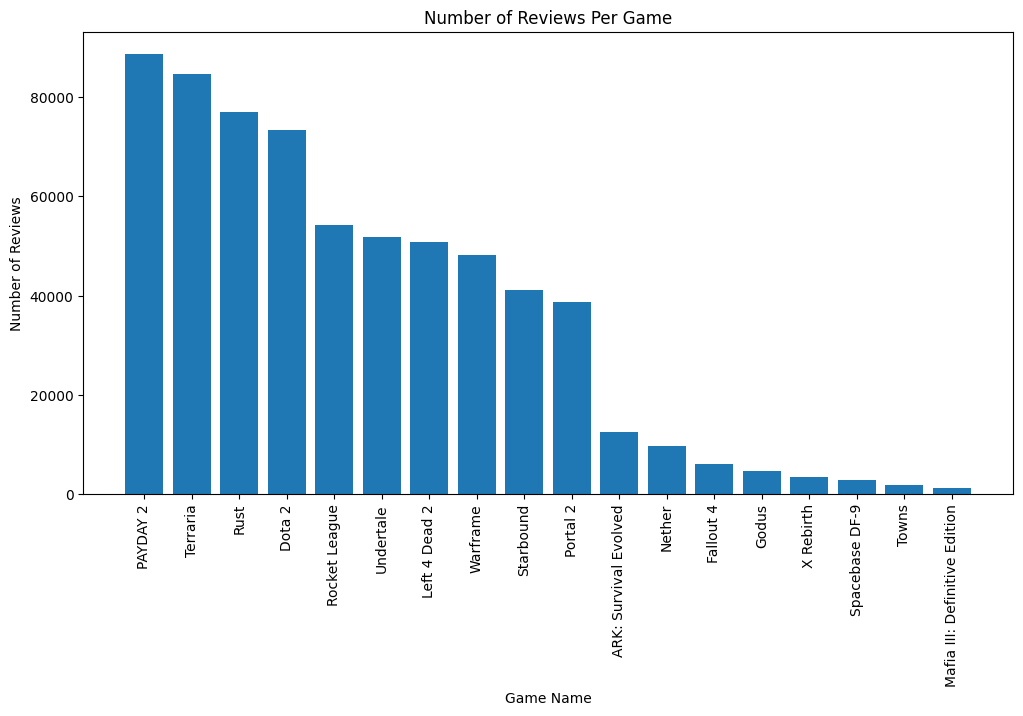

In [5]:
reviews_per_game = reviews[['app_name', 'review_text']].groupby('app_name').count().reset_index().sort_values('review_text', ascending=False)
fig, axs = plt.subplots(figsize=(12, 6))
axs.set_title("Number of Reviews Per Game")
axs.set_xlabel("Game Name")
axs.set_ylabel("Number of Reviews")
axs.bar(
    reviews_per_game['app_name'],
    reviews_per_game['review_text']
)
axs.tick_params('x', labelrotation=90)

# Ratings of Games

In [6]:
ratings[['name', 'overall_review', 'overall_score']].sort_values('overall_score', ascending=False)

,name,overall_review,overall_score
0,Terraria,Overwhelmingly Positive,9
3,Undertale,Overwhelmingly Positive,9
7,Portal 2,Overwhelmingly Positive,9
5,Left 4 Dead 2,Overwhelmingly Positive,9
1,Dota 2,Very Positive,8
2,Rocket League,Very Positive,8
6,Warframe,Very Positive,8
9,Starbound,Positive,7
4,Rust,Mostly Positive,6
8,PAYDAY 2,Mixed,5


# Problem 1 - Assign a Rating to a Game Based on Its Reviews

## Zero Shot Prompting Approach

**Idea**: I will give the LLM a user review and I will ask it to provide a rating for that review based on the scoring system. This will be done for some of the reviews of a given game and then their scores can be averaged out to find out the final rating.

In [9]:
import time
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI, HarmBlockThreshold, HarmCategory 

os.environ['GOOGLE_API_KEY'] = os.environ['GOOGLE_GENAI_API_KEY']
llm = ChatGoogleGenerativeAI(model="gemini-pro")
result = llm.invoke("Say hello!")

In [11]:
PROMPT = """
ROLE:
-----
You are an expert Quality Controller in the Video Game Industry. 
You are proficient in analysing user reviews and quantifying the rating of a game based on the review.

TASK:
-----
You will be provided a user review, for that user review you will provide a rating from 1 - 9, based on the RATING SYSTEM.

RATING SYSTEM:
--------------
9 - Overwhelmingly Positive
8 - Very Positive
7 - Positive
6 - Mostly Positive
5 - Mixed
4 - Mostly Negative
3 - Negative
2 - Very Negative
1 - Overwhelmingly Negative

INPUT FORMAT:
-------------
Input is provided in the following format <REVIEW ID>|<REVIEW>.

OUTPUT:
-------
For each <REVIEW> present in the INPUT, 
provide the output as <REVIEW ID> (ID Of the Review from the Input) | <RATING> (Rating of the Review from the Rating system)

INPUT:
------
REVIEW ID|REVIEW
{}
"""

reviews_to_rate = reviews[reviews['app_name'] == 'Nether'].sample(1000)

safety_settings={
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE
}

llm = ChatGoogleGenerativeAI(model="gemini-pro", safety_settings=safety_settings)

In [17]:
BATCH_SIZE = 30
ratings = []

for i in range(0, reviews_to_rate.shape[0] - BATCH_SIZE):
    review_id = reviews_to_rate.iloc[i:i+BATCH_SIZE]['review_id'].tolist()
    review_text = reviews_to_rate.iloc[i:i+BATCH_SIZE]['review_text'].tolist()
    user_input = "\n".join([f"{_id}|{txt}" for _id, txt in zip(review_id, review_text)])
    prediction = llm.invoke(PROMPT.format(user_input))
    ratings.append(prediction.content)
    time.sleep(1)

In [23]:
predicted_ratings = []
for r in ratings:
    individual_ratings = r.split("\n")
    for i in individual_ratings:
        try:
            predicted_ratings.append(
                {
                    'review_id': int(i.split("|")[0]),
                    'rating': int(i.split("|")[1])
                }
            )
        except ValueError as e:
            continue

In [26]:
pd.DataFrame(predicted_ratings)['rating'].mean()

4.018130699635944